# GREEDY DECODING

In [ ]:
class GreedySearchDecoder(object):
  pass

# BEAM SEARCH DECODING

In [ ]:
class BeamSearchDecoder(object):
  pass


Text cell <vWjTMgX5BLcG>
# %% [markdown]
# GREEDY DECODING

Code cell <Gs3Q0CM_BZb0>
# %% [code]
class GreedySearchDecoder(object):

    def __init__(self, symbol_set):
        self.symbol_set = symbol_set


    def decode(self, y_probs):
        decoded_path = []
        blank = 0
        path_prob = 1
        self.symbol_set.insert(0,'-')
        seq_len = len(y_probs[0])
        for seq in range(seq_len):
            prob = np.squeeze(y_probs[:, seq, :])
            idx = np.argmax(prob)
            decoded_path.append(self.symbol_set[idx])
            path_prob*=prob[idx]

        fin = decoded_path[0]

        for s in range(1, len(decoded_path)):
            if fin[-1] != decoded_path[s]:
                fin+=decoded_path[s]

        return "".join(fin.split("-")), path_prob

Text cell <hx0WUUqMCRYI>
# %% [markdown]
# BEAM SEARCH DECODING

Code cell <DeqcAKbxBmjG>
# %% [code]
class BeamSearchDecoder(object):

    def __init__(self, symbol_set, beam_width):
        """

        Initialize instance variables

        Argument(s)
        -----------

        symbol_set [list[str]]:
            all the symbols (the vocabulary without blank)

        beam_width [int]:
            beam width for selecting top-k hypotheses for expansion

        """

        self.symbol_set = symbol_set
        self.beam_width = beam_width

    def decode(self, y_probs):
        """

        Perform beam search decoding

        Input
        -----

        y_probs [np.array, dim=(len(symbols) + 1, seq_length, batch_size)]
			batch size for part 1 will remain 1, but if you plan to use your
			implementation for part 2 you need to incorporate batch_size

        Returns
        -------

        forward_path [str]:
            the symbol sequence with the best path score (forward probability)

        merged_path_scores [dict]:
            all the final merged paths with their scores

        """

        self.y_probs = y_probs
        self.path_score = {}
        self.blank_path_score = {}
        self.symbol_set.insert(0,'')
        seq_len = len(y_probs[0])
        print("T = 0\n")
        new_path_with_terminal_blanks, new_path_with_terminal_symbols, new_blank_path_score, new_path_score = self.initialize_paths(self.symbol_set, y_probs[:, 0, :])
        print("Current paths with terminal blanks", new_path_with_terminal_blanks)
        print("Current blank paths score", new_blank_path_score)
        print("\n")
        print("Current paths with terminal symbols", new_path_with_terminal_symbols)
        print("Current symbol paths score", new_path_score)


        for seq in range(1, seq_len):
            print("\n\n")
            print("T = " + str(seq) + "\n")

            prob = np.squeeze(y_probs[:, seq, :])
            paths_with_terminal_blank, paths_with_terminal_symbol, self.blank_path_score, self.path_score = self.prune( new_path_with_terminal_blanks, new_path_with_terminal_symbols, new_blank_path_score, new_path_score, self.beam_width)  # First extend paths by a blank
            new_path_with_terminal_blanks, new_blank_path_score = self.extend_with_blank(paths_with_terminal_blank, paths_with_terminal_symbol, prob)  # Next extend paths by a symbol
            new_path_with_terminal_symbols, new_path_score = self.extend_with_symbol(paths_with_terminal_blank, paths_with_terminal_symbol, self.symbol_set, prob)
            print("Current paths with terminal blanks")
            pprint.pprint(new_path_with_terminal_blanks)
            print("Current blank paths score")
            pprint.pprint(new_blank_path_score)
            print("\n")
            print("Current paths with terminal symbols")
            pprint.pprint(new_path_with_terminal_symbols)
            print("Current symbol paths score" )
            pprint.pprint(new_path_score)


        merged_path, final_path_score = self.merge_identical_path(new_path_with_terminal_blanks, new_blank_path_score, new_path_with_terminal_symbols, new_path_score)
        best_path = max(final_path_score, key=final_path_score.get)

        print("\n\n")

        print("Final Path Scores \n")
        pprint.pprint(final_path_score)
        print("\n\n Final Path \n", best_path)
        return best_path, final_path_score

    def initialize_paths(self, symbol_set, y_probs):
        initial_blank_path_score = {}
        initial_path_score = {}
        initial_path_with_final_blank = set()
        initial_path_with_final_symbol = set()

        path = ""
        initial_blank_path_score[path] = y_probs[0][0]
        initial_path_with_final_blank.add(path)

        for i in range(1, len(symbol_set)):
            path = symbol_set[i]
            initial_path_score[path] = y_probs[i][0]
            initial_path_with_final_symbol.add(path)

        return initial_path_with_final_blank, initial_path_with_final_symbol, initial_blank_path_score, initial_path_score

    def prune(self, path_with_terminal_blanks, path_with_terminal_symbols, blank_path_score, path_score, beam_width):
        prune_blank_path_score = {}
        prune_path_score = {}
        score_list = []

        for p in path_with_terminal_blanks:
            score_list.append(blank_path_score[p])

        for p in path_with_terminal_symbols:
            score_list.append(path_score[p])

        score_list = sorted(score_list, reverse=True)
        cutoff = score_list[beam_width-1] if beam_width < len(score_list) else score_list[-1]

        prune_path_with_terminal_blanks = set()
        prune_path_with_terminal_symbols = set()

        for p in path_with_terminal_blanks:
            if blank_path_score[p] >= cutoff:
                prune_path_with_terminal_blanks.add(p)
                prune_blank_path_score[p] = blank_path_score[p]

        for p in path_with_terminal_symbols:
            if path_score[p] >= cutoff:
                prune_path_with_terminal_symbols.add(p)
                prune_path_score[p] = path_score[p]

        return prune_path_with_terminal_blanks, prune_path_with_terminal_symbols, prune_blank_path_score, prune_path_score

    def extend_with_blank(self, paths_with_terminal_blank, paths_with_terminal_symbol, prob):
        updated_paths_with_terminal_blank = set()
        updated_blank_path_score = {}

        for p in paths_with_terminal_blank:
            updated_paths_with_terminal_blank.add(p)
            updated_blank_path_score[p] = self.blank_path_score[p]*prob[0]

        for p in paths_with_terminal_symbol:
            if p in updated_paths_with_terminal_blank:
                updated_blank_path_score[p] += self.path_score[p]*prob[0]
            else:
                updated_paths_with_terminal_blank.add(p)
                updated_blank_path_score[p] = self.path_score[p]*prob[0]

        return updated_paths_with_terminal_blank,updated_blank_path_score


    def extend_with_symbol(self, paths_with_terminal_blank, paths_with_terminal_symbol, symbol_set, prob):
        updated_paths_with_terminal_symbols = set()
        updated_path_score = {}

        for p in paths_with_terminal_blank:
            for c in range(1, len(symbol_set)):
                newpath = p + symbol_set[c]
                updated_paths_with_terminal_symbols.add(newpath)
                updated_path_score[newpath] = self.blank_path_score[p]*prob[c]

        for p in paths_with_terminal_symbol:
            for c in range(1, len(symbol_set)):
                newpath = p if p[-1] == symbol_set[c] else p + symbol_set[c]
                if newpath in updated_paths_with_terminal_symbols:
                    updated_path_score[newpath] += self.path_score[p]*prob[c]
                else:
                    updated_paths_with_terminal_symbols.add(newpath)
                    updated_path_score[newpath] = self.path_score[p]*prob[c]

        return updated_paths_with_terminal_symbols, updated_path_score


    def merge_identical_path(self, path_with_terminal_blank, blank_path_score, path_with_terminal_symbols, path_score):
        merged_paths = path_with_terminal_symbols
        final_path_scores = path_score

        for p in path_with_terminal_blank:
            if p in merged_paths:
                final_path_scores[p] += blank_path_score[p]
            else:
                merged_paths.add(p)
                final_path_scores[p] = blank_path_score[p]

        return merged_paths, final_path_scores

Text cell <mXogbRmLBsKm>
# %% [markdown]
# DECODE

Code cell <BQTldjAlBxPW>
# %% [code]
import numpy as np
import pprint

y_probs = np.array([
    [0.140, 0.391, 0.197, 0.271],
    [0.257, 0.096, 0.341, 0.305],
    [0.248, 0.402, 0.267, 0.083],
    [0.149, 0.336, 0.358, 0.197]
])

y_probs = np.expand_dims(y_probs.T, 2)

Code cell <SBQ2dwuxC6AE>
# %% [code]
symbolSets = ["a", "b", "c"]

greedy_decoder = GreedySearchDecoder(symbolSets)

user_best_path, user_score = greedy_decoder.decode(y_probs)

print("\tGREEDY DECODING")
print("Best Path: ", user_best_path)
print("Best Path Score: ", user_score)
Execution output from Mar 17, 2023 11:31 AM
0KB
	Stream
		GREEDY DECODING
		Best Path:  abab
		Best Path Score:  0.019188464196

Code cell <cyANqutKDZwm>
# %% [code]
symbolSets = ["a", "b", "c"]
beamWidth = 3
print("\tBEAM SEARCH DECODING")
beam_decoder = BeamSearchDecoder(symbolSets, beamWidth)
BestPath, MergedPathScores = beam_decoder.decode(y_probs)
# Execution output from Mar 17, 2023 11:32 AM
# 2KB
# 	Stream
# 		BEAM SEARCH DECODING
# 		T = 0

# 		Current paths with terminal blanks {''}
# 		Current blank paths score {'': 0.14}


# 		Current paths with terminal symbols {'c', 'b', 'a'}
# 		Current symbol paths score {'a': 0.391, 'b': 0.197, 'c': 0.271}



# 		T = 1

# 		Current paths with terminal blanks
# 		{'c', 'b', 'a'}
# 		Current blank paths score
# 		{'a': 0.100487, 'b': 0.050629, 'c': 0.069647}


# 		Current paths with terminal symbols
# 		{'ac', 'ba', 'a', 'ca', 'cb', 'b', 'ab', 'c', 'bc'}
# 		Current symbol paths score
# 		{'a': 0.037536,
# 		 'ab': 0.133331,
# 		 'ac': 0.119255,
# 		 'b': 0.06717700000000001,
# 		 'ba': 0.018912,
# 		 'bc': 0.060085,
# 		 'c': 0.082655,
# 		 'ca': 0.026016,
# 		 'cb': 0.09241100000000001}



# 		T = 2

# 		Current paths with terminal blanks
# 		{'ac', 'a', 'ab'}
# 		Current blank paths score
# 		{'a': 0.024920776000000002, 'ab': 0.033066088, 'ac': 0.02957524}


# 		Current paths with terminal symbols
# 		{'ac', 'abc', 'aba', 'aca', 'aa', 'ab', 'acb'}
# 		Current symbol paths score
# 		{'aa': 0.040395774,
# 		 'ab': 0.06242940600000001,
# 		 'aba': 0.053599062,
# 		 'abc': 0.011066473,
# 		 'ac': 0.018238586,
# 		 'aca': 0.047940510000000006,
# 		 'acb': 0.031841085000000005}



# 		T = 3

# 		Current paths with terminal blanks
# 		{'aba', 'aca', 'ab'}
# 		Current blank paths score
# 		{'ab': 0.009301981494000001,
# 		 'aba': 0.007986260238,
# 		 'aca': 0.0071431359900000005}


# 		Current paths with terminal symbols
# 		{'abc', 'acab', 'aba', 'acac', 'abab', 'aca', 'abac', 'ab'}
# 		Current symbol paths score
# 		{'ab': 0.022349727348,
# 		 'aba': 0.03898556524800001,
# 		 'abab': 0.019188464196,
# 		 'abac': 0.010559015214000001,
# 		 'abc': 0.012298592982000003,
# 		 'aca': 0.016108011360000004,
# 		 'acab': 0.01716270258,
# 		 'acac': 0.009444280470000002}



# 		Final Path Scores

# 		{'ab': 0.031651708842,
# 		 'aba': 0.04697182548600001,
# 		 'abab': 0.019188464196,
# 		 'abac': 0.010559015214000001,
# 		 'abc': 0.012298592982000003,
# 		 'aca': 0.023251147350000004,
# 		 'acab': 0.01716270258,
# 		 'acac': 0.009444280470000002}



# DECODE

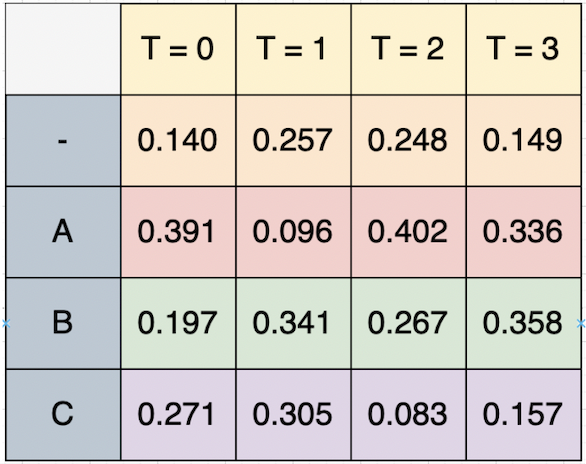

In [ ]:
import numpy as np
import pprint

y_probs = np.array([
    [0.140, 0.391, 0.197, 0.271],
    [0.257, 0.096, 0.341, 0.305],
    [0.248, 0.402, 0.267, 0.083],
    [0.149, 0.336, 0.358, 0.197]
])

y_probs = np.expand_dims(y_probs.T, 2)

In [ ]:
symbolSets = ["a", "b", "c"]
greedy_decoder = GreedySearchDecoder(symbolSets)

print("\tGREEDY DECODING")

user_best_path, user_score = greedy_decoder.decode(y_probs)
print("Best Path: ", user_best_path)
print("Best Path Score: ", user_score)

	GREEDY DECODING
Best Path:  abab
Best Path Score:  0.019188464196


In [ ]:
symbolSets = ["a", "b", "c"]
beamWidth = 3

print("\tBEAM SEARCH DECODING")
beam_decoder = BeamSearchDecoder(symbolSets, beamWidth)
BestPath, MergedPathScores = beam_decoder.decode(y_probs)

	BEAM SEARCH DECODING
T = 0

Current paths with terminal blanks {''}
Current blank paths score {'': 0.14}


Current paths with terminal symbols {'c', 'b', 'a'}
Current symbol paths score {'a': 0.391, 'b': 0.197, 'c': 0.271}



T = 1

Current paths with terminal blanks
{'c', 'b', 'a'}
Current blank paths score
{'a': 0.100487, 'b': 0.050629, 'c': 0.069647}


Current paths with terminal symbols
{'ac', 'ba', 'a', 'ca', 'cb', 'b', 'ab', 'c', 'bc'}
Current symbol paths score
{'a': 0.037536,
 'ab': 0.133331,
 'ac': 0.119255,
 'b': 0.06717700000000001,
 'ba': 0.018912,
 'bc': 0.060085,
 'c': 0.082655,
 'ca': 0.026016,
 'cb': 0.09241100000000001}



T = 2

Current paths with terminal blanks
{'ac', 'a', 'ab'}
Current blank paths score
{'a': 0.024920776000000002, 'ab': 0.033066088, 'ac': 0.02957524}


Current paths with terminal symbols
{'ac', 'abc', 'aba', 'aca', 'aa', 'ab', 'acb'}
Current symbol paths score
{'aa': 0.040395774,
 'ab': 0.06242940600000001,
 'aba': 0.053599062,
 'abc': 0.011066473

BEAM.png